# CNN Image2Image - Colorization

### 1. Import Libraries and dataset

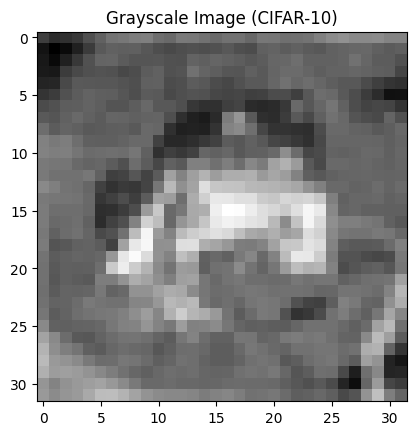

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import tensorflow as tf

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the images to grayscale for colorization (only for the input)
x_train_gray = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
x_test_gray = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])

# Expand the grayscale images to have 1 channel (the model expects 3D input)
x_train_gray = np.expand_dims(x_train_gray, axis=-1)
x_test_gray = np.expand_dims(x_test_gray, axis=-1)

# Display an example grayscale image
plt.imshow(x_train_gray[0], cmap='gray')
plt.title("Grayscale Image (CIFAR-10)")
plt.show()

### 2. Define U-Net Model for Colorization

In [2]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (downsampling)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder (upsampling)
    up4 = layers.UpSampling2D((2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])  # Skip connection
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D((2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])  # Skip connection
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer (3 channels for RGB)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    model = models.Model(inputs, outputs)
    return model

# Build the model with input shape for grayscale images (e.g., 32x32x1 for CIFAR-10)
input_shape = (32, 32, 1)
model = build_unet(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,882,115 (7.18 MB)

 Trainable params: 1,882,115 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def build_unet_stride(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (downsampling using strides)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1_1 = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(conv1)  # Stride instead of max pooling

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv1_1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2_1 = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(conv2)  # Stride instead of max pooling

    # Bottleneck (bottom layer)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv2_1)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder (upsampling)
    up4 = layers.UpSampling2D((2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])  # Skip connection
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D((2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])  # Skip connection
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer (3 channels for RGB)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    model_stride = models.Model(inputs, outputs)
    return model_stride

# Build the model with input shape for grayscale images (e.g., 32x32x1 for CIFAR-10)
input_shape = (32, 32, 1)
model_stride = build_unet_stride(input_shape)
model_stride.summary()

# Compile the model
model_stride.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_stride.fit(x_train_gray, x_train, epochs=10, batch_size=32, validation_split=0.1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 32, 32,    │        640 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_115[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 16, 16,    │     36,928 │ conv2d_116[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 16, 16,    │     73,856 │ conv2d_117[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 16, 16,    │    147,584 │ conv2d_118[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 8, 8, 128) │    147,584 │ conv2d_119[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 8, 8, 256) │    295,168 │ conv2d_120[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 8, 8, 256) │    590,080 │ conv2d_121[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (None, 16, 16,    │          0 │ conv2d_122[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 16, 16,    │          0 │ up_sampling2d_13… │
│ (Concatenate)       │ 384)              │            │ conv2d_119[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 16, 16,    │    442,496 │ concatenate_17[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 16, 16,    │    147,584 │ conv2d_123[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_14    │ (None, 32, 32,    │          0 │ conv2d_124[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 32, 32,    │          0 │ up_sampling2d_14… │
│ (Concatenate)       │ 192)              │            │ conv2d_116[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 32, 32,    │    110,656 │ concatenate_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_125[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 32, 32, 3) │        195 │ conv2d_126[0][0]

 Total params: 2,066,627 (7.88 MB)

 Trainable params: 2,066,627 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 562s 397ms/step - loss: 0.0101 - val_loss: 0.0054
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 550s 391ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 549s 390ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 541s 385ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 546s 388ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 549s 390ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 541s 384ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 542s 385ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 544s 387ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 556s 395ms/step - loss: 0.0043 - val_loss: 0.0053


### 3. Compile the Model

In [3]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### 4. Train the Model

In [4]:
# Train the model
model.fit(x_train_gray, x_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1833s 1s/step - loss: 0.0103 - val_loss: 0.0056
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 533s 379ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 525s 373ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 571s 406ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 537s 382ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 529s 376ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 576s 409ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 754s 536ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 763s 542ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 620s 441ms/step - loss: 0.0046 - val_loss: 0.0049


### 5. Evaluate and Visualize the Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


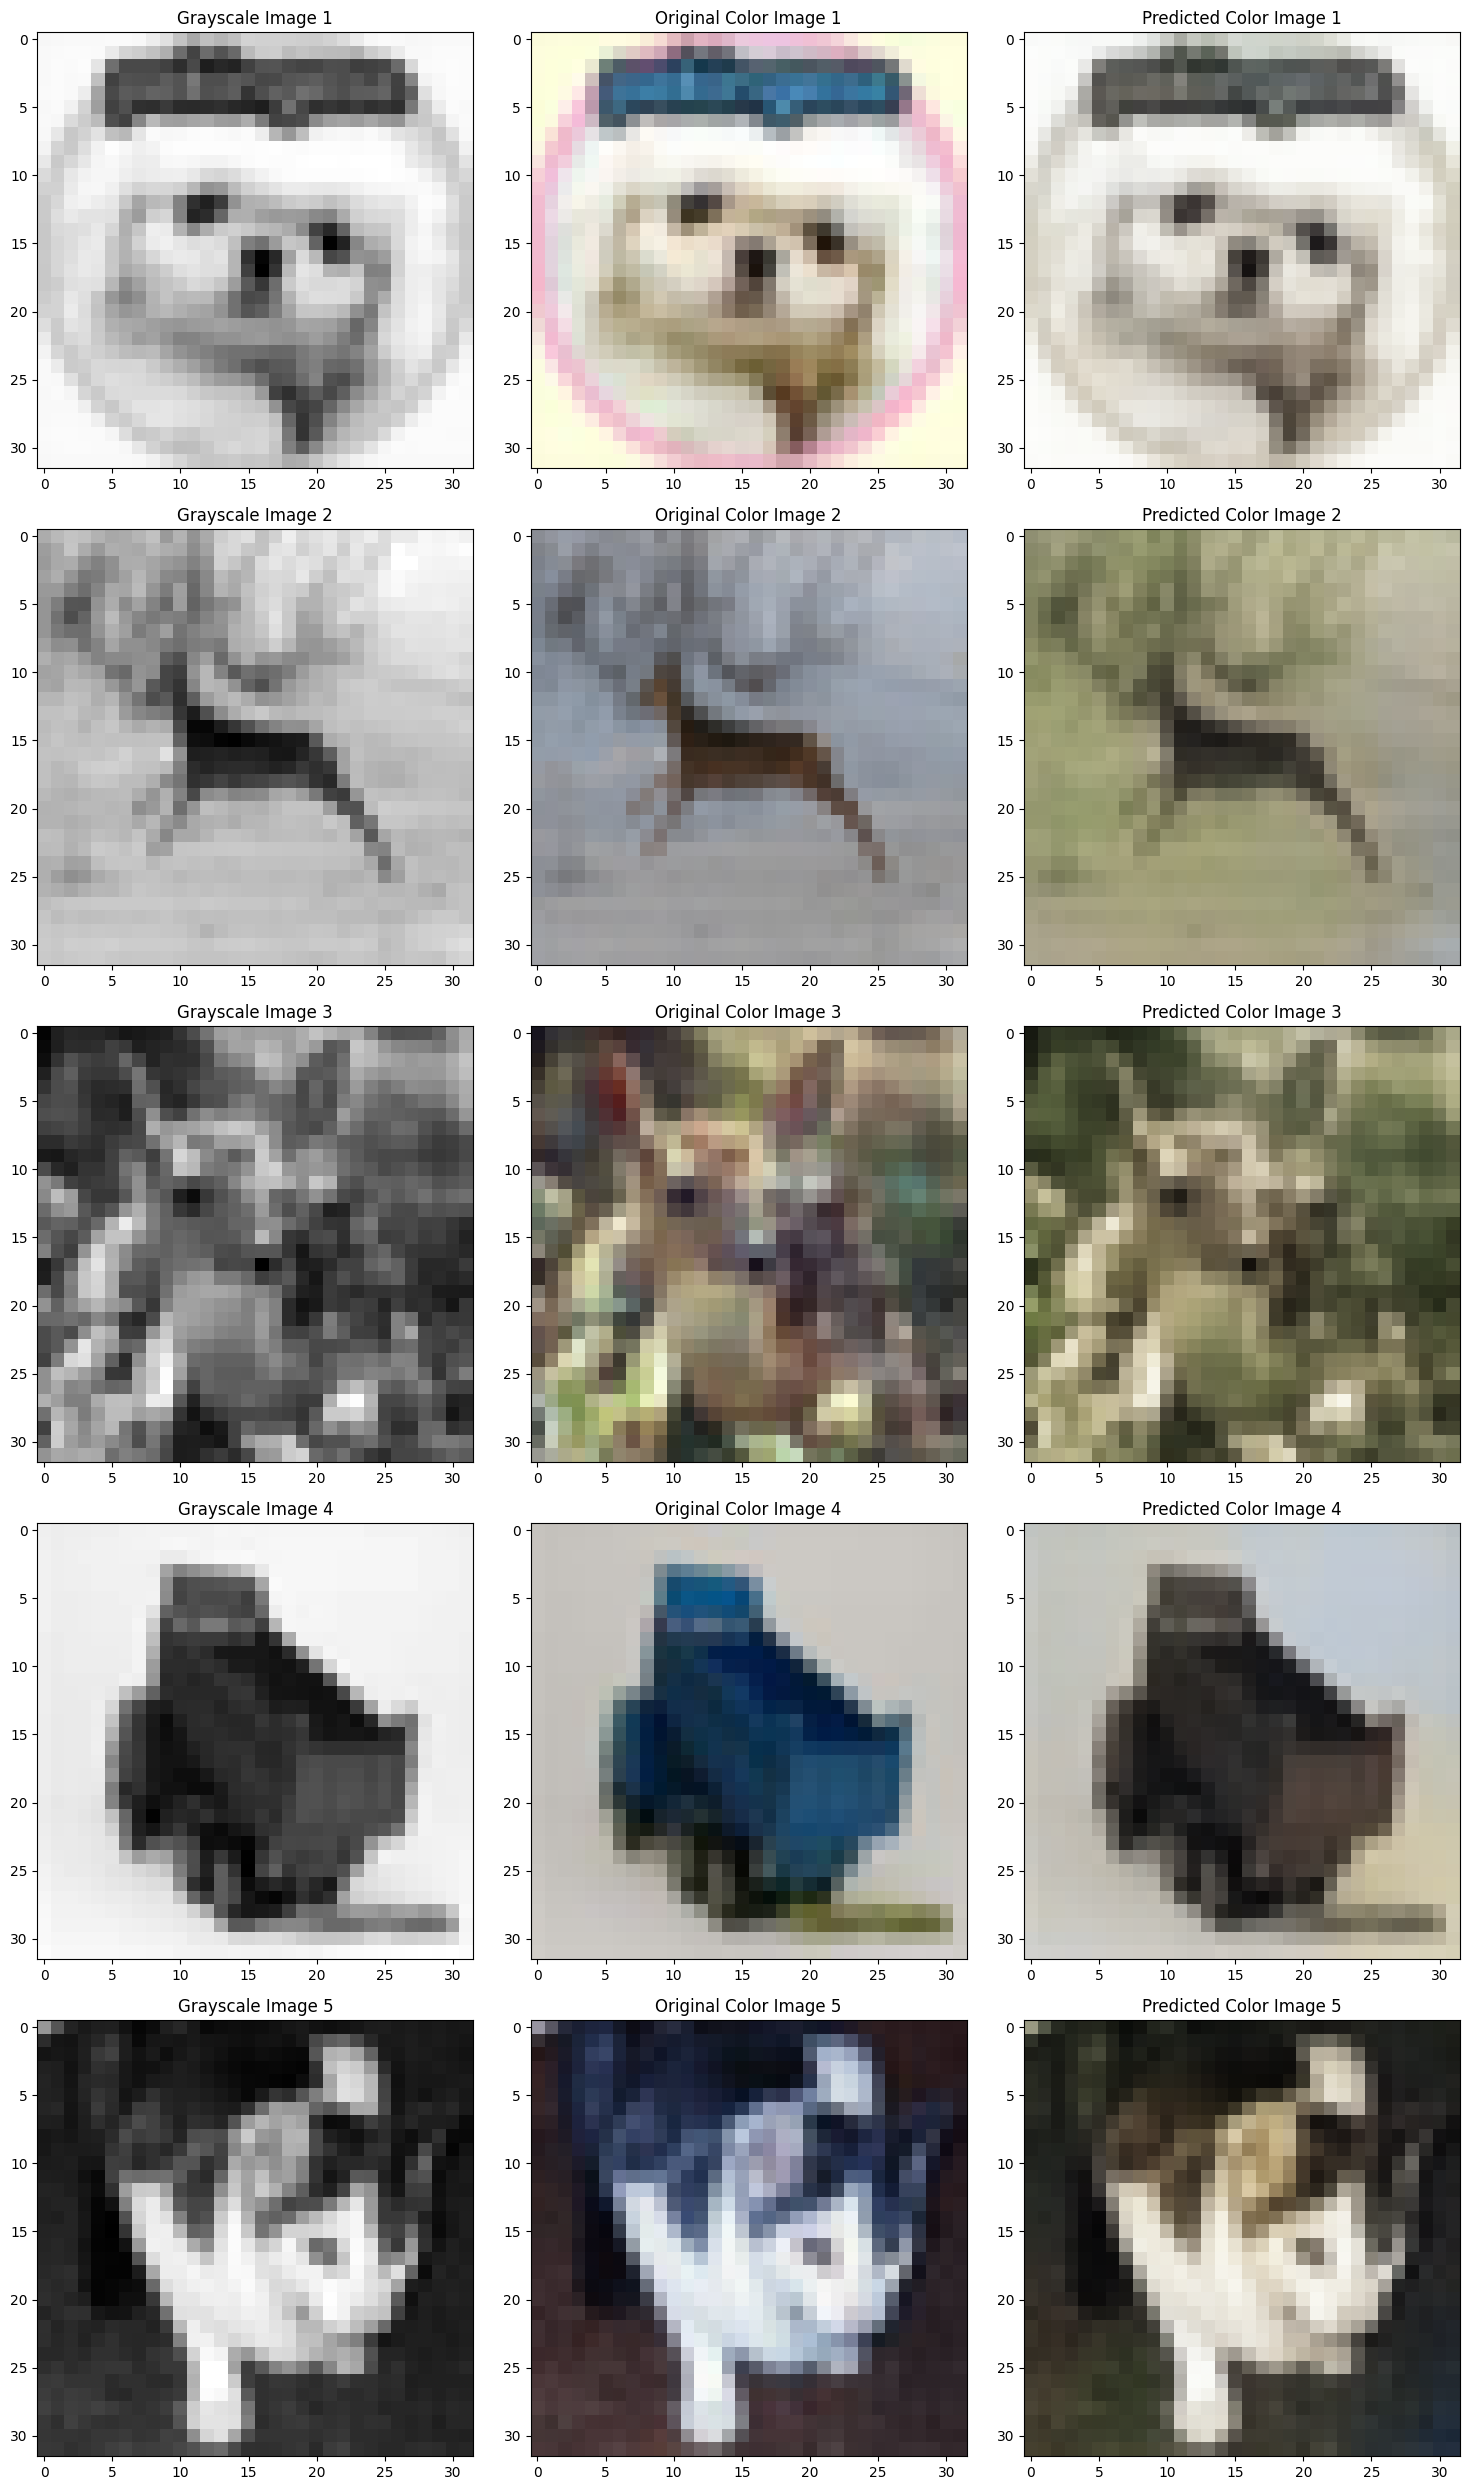

In [38]:
import random

# Function to visualize results for multiple random images
def visualize_random_results(x_gray, x_color, model, num_images=5):
    # Randomly select indices
    random_indices = random.sample(range(len(x_gray)), num_images)

    plt.figure(figsize=(15, 5 * num_images))

    for i, idx in enumerate(random_indices):
        grayscale_image = x_gray[idx]
        color_image = x_color[idx]
        
        # Predict the colorization
        predicted_image = model.predict(np.expand_dims(grayscale_image, axis=0))

        # Plot grayscale, original color, and predicted color images
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(grayscale_image.squeeze(), cmap='gray')
        plt.title(f'Grayscale Image {i+1}')
        
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(color_image)
        plt.title(f'Original Color Image {i+1}')
        
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predicted_image.squeeze())
        plt.title(f'Predicted Color Image {i+1}')

    plt.tight_layout()
    plt.show()

# Visualize 5 random images
visualize_random_results(x_test_gray, x_test, model, num_images=5)


### 6. Evaluate scores

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import random

def evaluate_model(model, x_gray, x_color, num_samples=100):
    """
    Evaluate the model on a random subset of the test data to save computation time.
    """
    indices = random.sample(range(len(x_gray)), min(num_samples, len(x_gray)))  # Randomly sample indices
    mse_scores = []
    mae_scores = []
    ssim_scores = []
    psnr_scores = []

    for idx in indices:
        grayscale_image = x_gray[idx]
        true_output = x_color[idx]

        # Predict the colorization
        predicted_output = model.predict(np.expand_dims(grayscale_image, axis=0)).squeeze()
        predicted_output = np.clip(predicted_output, 0, 1)  # Ensure valid range

        # Compute metrics
        mse_scores.append(mean_squared_error(true_output.flatten(), predicted_output.flatten()))
        mae_scores.append(mean_absolute_error(true_output.flatten(), predicted_output.flatten()))
        psnr_scores.append(psnr(true_output, predicted_output, data_range=1.0))
        #ssim_scores.append(ssim(true_output, predicted_output, channel_axis=-1, data_range=1.0))

    # Print metrics
    print(f"Evaluation on {len(indices)} samples:")
    print(f"Mean MSE: {np.mean(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f}")
    print(f"Mean PSNR: {np.mean(psnr_scores):.4f} dB")
    #print(f"Mean SSIM: {np.mean(ssim_scores):.4f}")

#evaluate_model(model, x_test_gray, x_test, num_samples=10000)

evaluate_model(model_stride, x_test_gray, x_test, num_samples=10000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

### 7. Test with our own image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


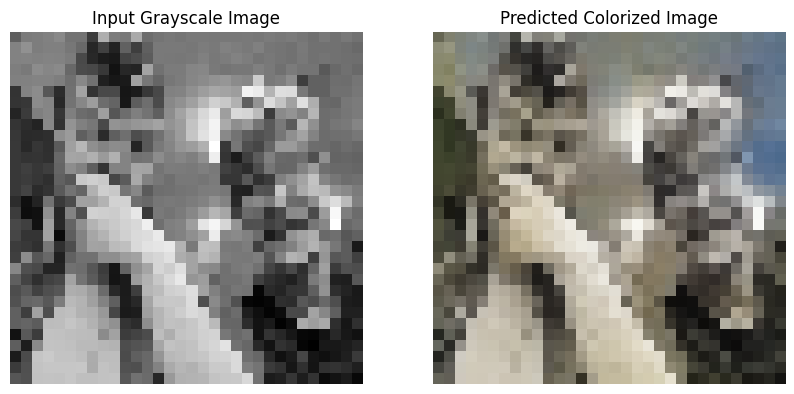

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image_path = 'Funny_image.jpg'  # Replace with your file path
target_size = (32, 32)  # Match the training size, e.g., 32x32 for CIFAR-10

# Load the image and resize
original_image = load_img(image_path, target_size=target_size)
original_image = img_to_array(original_image) / 255.0  # Normalize to [0, 1]

# Step 2: Convert the image to grayscale
grayscale_image = np.dot(original_image[..., :3], [0.299, 0.587, 0.114])  # Convert to grayscale
grayscale_image = np.expand_dims(grayscale_image, axis=-1)  # Add channel dimension

# Step 3: Expand dimensions to match model input
input_image = np.expand_dims(grayscale_image, axis=0)  # Shape: (1, height, width, 1)

# Step 4: Predict the output using the trained model
predicted_output = model.predict(input_image)

# Step 5: Post-process the prediction
predicted_output = np.clip(predicted_output[0], 0, 1)  # Remove batch dimension, clip values to [0, 1]

# Step 6: Display the results
plt.figure(figsize=(10, 5))

# Display Grayscale Input
plt.subplot(1, 2, 1)
plt.imshow(grayscale_image.squeeze(), cmap='gray')
plt.title('Input Grayscale Image')
plt.axis('off')

# Display Predicted Colorized Image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output)
plt.title('Predicted Colorized Image')
plt.axis('off')

plt.show()


### 8. Evaluate and Visualize the Results, Same iamges

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


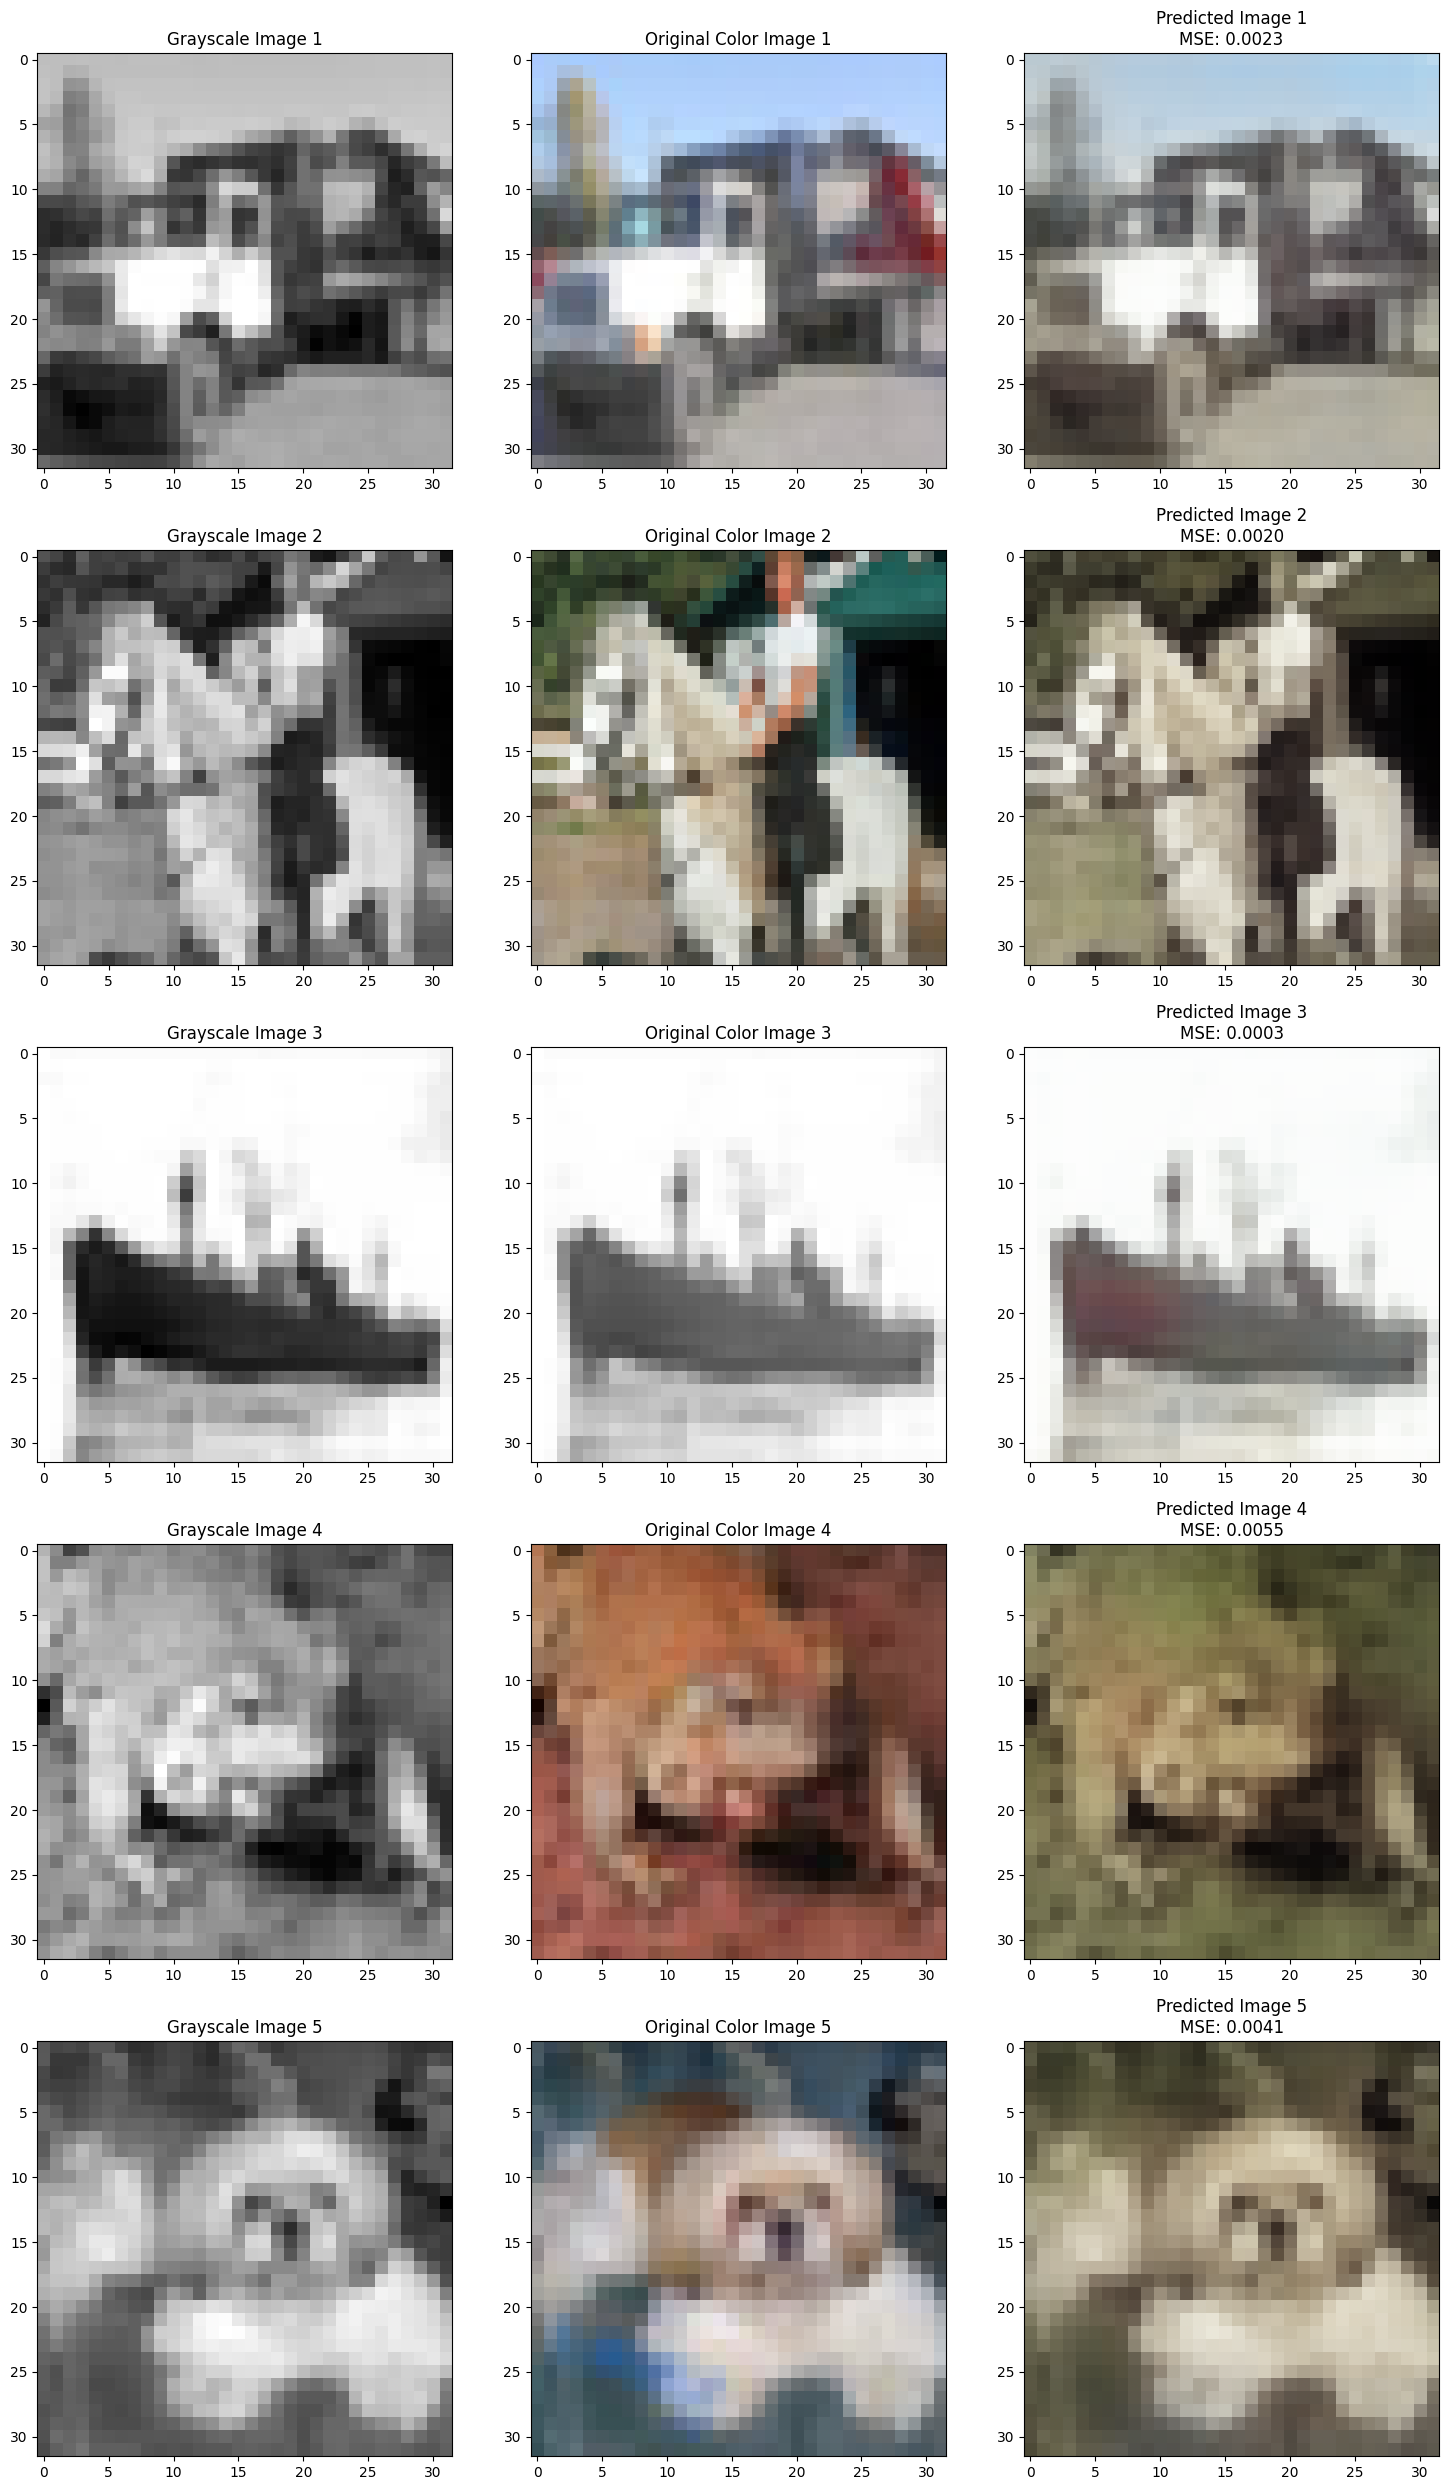

In [41]:
from sklearn.metrics import mean_squared_error

# Function to visualize results for fixed images with MSE displayed
def visualize_fixed_results_with_mse(x_gray, x_color, model, fixed_indices=[0, 1, 2, 3, 4]):
    """
    Visualizes grayscale, original color, and predicted color images for fixed indices,
    and calculates Mean Squared Error (MSE) for each image.
    
    Parameters:
    - x_gray: Array of grayscale images.
    - x_color: Array of original color images.
    - model: The colorization model.
    - fixed_indices: List of specific indices to visualize. Default: [0, 1, 2, 3, 4].
    """
    num_images = len(fixed_indices)
    plt.figure(figsize=(15, 5 * num_images))

    for i, idx in enumerate(fixed_indices):
        grayscale_image = x_gray[idx]
        color_image = x_color[idx]
        
        # Predict the colorization
        predicted_image = model.predict(np.expand_dims(grayscale_image, axis=0)).squeeze()
        
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(color_image.flatten(), predicted_image.flatten())
        
        # Plot grayscale, original color, and predicted color images
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(grayscale_image.squeeze(), cmap='gray')
        plt.title(f'Grayscale Image {i+1}')
        
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(color_image)
        plt.title(f'Original Color Image {i+1}')
        
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predicted_image)
        plt.title(f'Predicted Image {i+1}\nMSE: {mse:.4f}')  # Display MSE in title

    plt.tight_layout()
    plt.show()

# Visualize the same 5 images each time with MSE displayed
#visualize_fixed_results_with_mse(x_test_gray, x_test, model, fixed_indices=[45, 56, 79, 5, 39])

visualize_fixed_results_with_mse(x_test_gray, x_test, model_stride, fixed_indices=[45, 56, 79, 5, 39])
